<a href="https://colab.research.google.com/github/dasamitansu159/Physic-Informed-Neural-Networks/blob/main/heateqn_2d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install deepxde

In [ ]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#defining the domain
Geometry = dde.geometry.Rectangle([0,0] , [1,1])
Time = dde.geometry.TimeDomain(0 , 1)
geotime = dde.geometry.GeometryXTime(Geometry , Time)

In [ ]:
#defining pde
def pde(x , u):
  du_dt = dde.grad.jacobian(u , x , i=0 , j=2)
  d2u_dx2 = dde.grad.hessian(u , x , i=0 , j=0)
  d2u_dy2 = dde.grad.hessian(u , x , i=0 , j=1)
  #taking alpha as 0.01
  return du_dt - 0.01*(d2u_dx2 + d2u_dy2)
#defining initial condition
def initial(x):
  return np.sin(np.pi*x[:,0:1])*np.sin(np.pi*x[:,1:2])
ic = dde.icbc.IC(geotime , initial , lambda _, on_initial : on_initial)

In [ ]:
# Boundary condition function
def boundary_left(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0)

def boundary_right(x, on_boundary):
    return on_boundary and np.isclose(x[0], 1)

def boundary_bottom(x, on_boundary):
    return on_boundary and np.isclose(x[1], 0)

def boundary_top(x, on_boundary):
    return on_boundary and np.isclose(x[1], 1)

# Define boundary conditions for all four sides
bc_left = dde.icbc.DirichletBC(geotime, lambda x: 0, boundary_left)
bc_right = dde.icbc.DirichletBC(geotime, lambda x: 0, boundary_right)
bc_bottom = dde.icbc.DirichletBC(geotime, lambda x: 0, boundary_bottom)
bc_top = dde.icbc.DirichletBC(geotime, lambda x: 0, boundary_top)

In [ ]:
#defining data
data = dde.data.TimePDE(geotime , pde , [ic , bc_left , bc_right , bc_top , bc_bottom] , num_domain = 800 , num_boundary = 500 , num_initial = 500)

In [ ]:
#defining neural network
layers = [3]+4*[32]+[1]
activation = 'tanh'
initializer = 'Glorot normal'
net = dde.nn.FNN(layers , activation , initializer)

In [ ]:
#defining model
model = dde.Model(data , net)
model.compile('adam' , lr = 0.001)

Compiling model...
Building feed-forward neural network...
'build' took 0.100820 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.004422 s



Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.40e-03, 5.90e-01, 7.10e-02, 1.21e-01, 2.07e-01, 1.52e-02]    [1.40e-03, 5.90e-01, 7.10e-02, 1.21e-01, 2.07e-01, 1.52e-02]    []  
1000      [5.10e-04, 8.97e-04, 2.06e-04, 4.06e-04, 3.91e-04, 1.50e-04]    [5.10e-04, 8.97e-04, 2.06e-04, 4.06e-04, 3.91e-04, 1.50e-04]    []  
2000      [2.90e-04, 1.37e-04, 8.79e-05, 2.05e-04, 1.82e-04, 9.20e-05]    [2.90e-04, 1.37e-04, 8.79e-05, 2.05e-04, 1.82e-04, 9.20e-05]    []  
3000      [2.16e-04, 7.33e-05, 3.99e-05, 8.98e-05, 9.97e-05, 8.08e-05]    [2.16e-04, 7.33e-05, 3.99e-05, 8.98e-05, 9.97e-05, 8.08e-05]    []  
4000      [1.84e-04, 6.40e-05, 3.07e-05, 6.18e-05, 8.62e-05, 7.43e-05]    [1.84e-04, 6.40e-05, 3.07e-05, 6.18e-05, 8.62e-05, 7.43e-05]    []  
5000      [1.68e-04, 6.00e-05, 2.53e-05, 5.06e-05, 7.96e-05, 6.93e-05]    [1.68e-04, 6.00e-05, 2.53e-05, 5.06e-05, 7

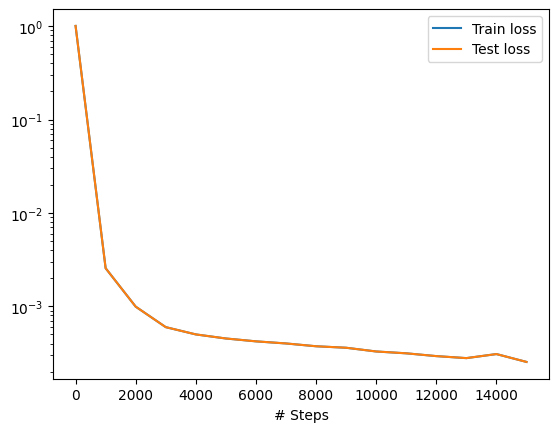

In [ ]:
loss , train_state = model.train(iterations = 15000)
dde.saveplot(loss , train_state)

In [ ]:
#test data creation
x = np.linspace(0 , 1 , 100)
y = np.linspace(0 , 1 , 100)
t = np.linspace(0 , 1 , 100)
X , Y , T = np.meshgrid(x , y , t)
x_flat = np.vstack([X.ravel() , Y.ravel() , T.ravel()]).T

In [ ]:
#making model to predict the created data
u_pred = model.predict(x_flat).reshape(100,100,100)

In [ ]:
#exact solution
u_exact = np.exp(-0.02 * np.pi**2 * T) * np.sin(np.pi * X) * np.sin(np.pi * Y)

In [ ]:
#error prediction
u_error = np.abs(u_pred - u_exact)
print(u_error.mean())

0.024879784708573223


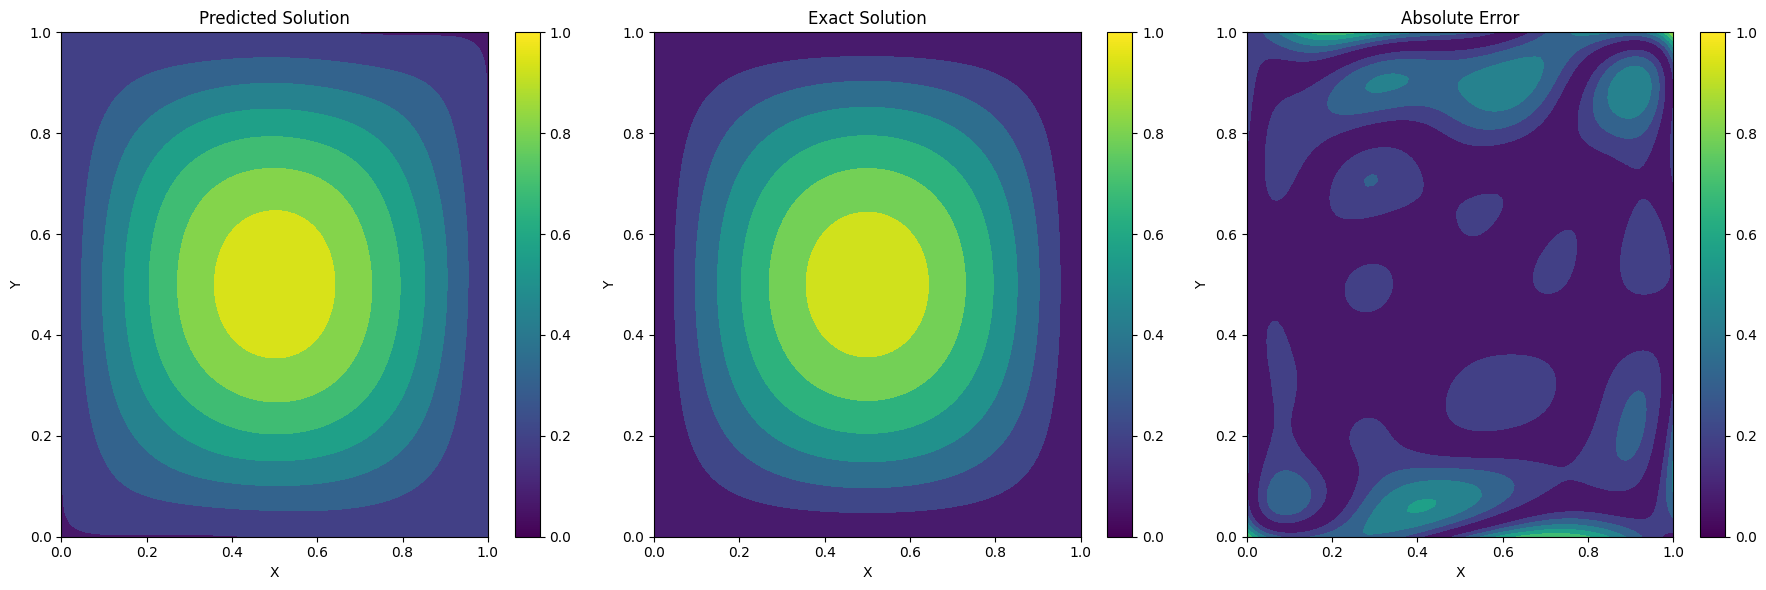

In [ ]:
#plotting graph
t_index = 0 #for t axis
fig , axis = plt.subplots(1 , 3 , figsize = (18,6))
#for u_pred
axis[0].contourf(X[:, :, t_index], Y[:, :, t_index], u_pred[:, :, t_index], cmap='viridis')
axis[0].set_title('Predicted Solution')
axis[0].set_xlabel('X')
axis[0].set_ylabel('Y')
fig.colorbar(axis[0].collections[0], ax=axis[0], orientation='vertical')
#for u_exact
axis[1].contourf(X[:, :, t_index], Y[:, :, t_index], u_exact[:, :, t_index], cmap='viridis')
axis[1].set_title('Exact Solution')
axis[1].set_xlabel('X')
axis[1].set_ylabel('Y')
fig.colorbar(axis[1].collections[0], ax=axis[1], orientation='vertical')
#for error
axis[2].contourf(X[:, :, t_index], Y[:, :, t_index], u_error[:, :, t_index], cmap='viridis')
axis[2].set_title('Absolute Error')
axis[2].set_xlabel('X')
axis[2].set_ylabel('Y')
fig.colorbar(axis[2].collections[0], ax=axis[2], orientation='vertical')
#showing the plot
plt.tight_layout()
plt.show()

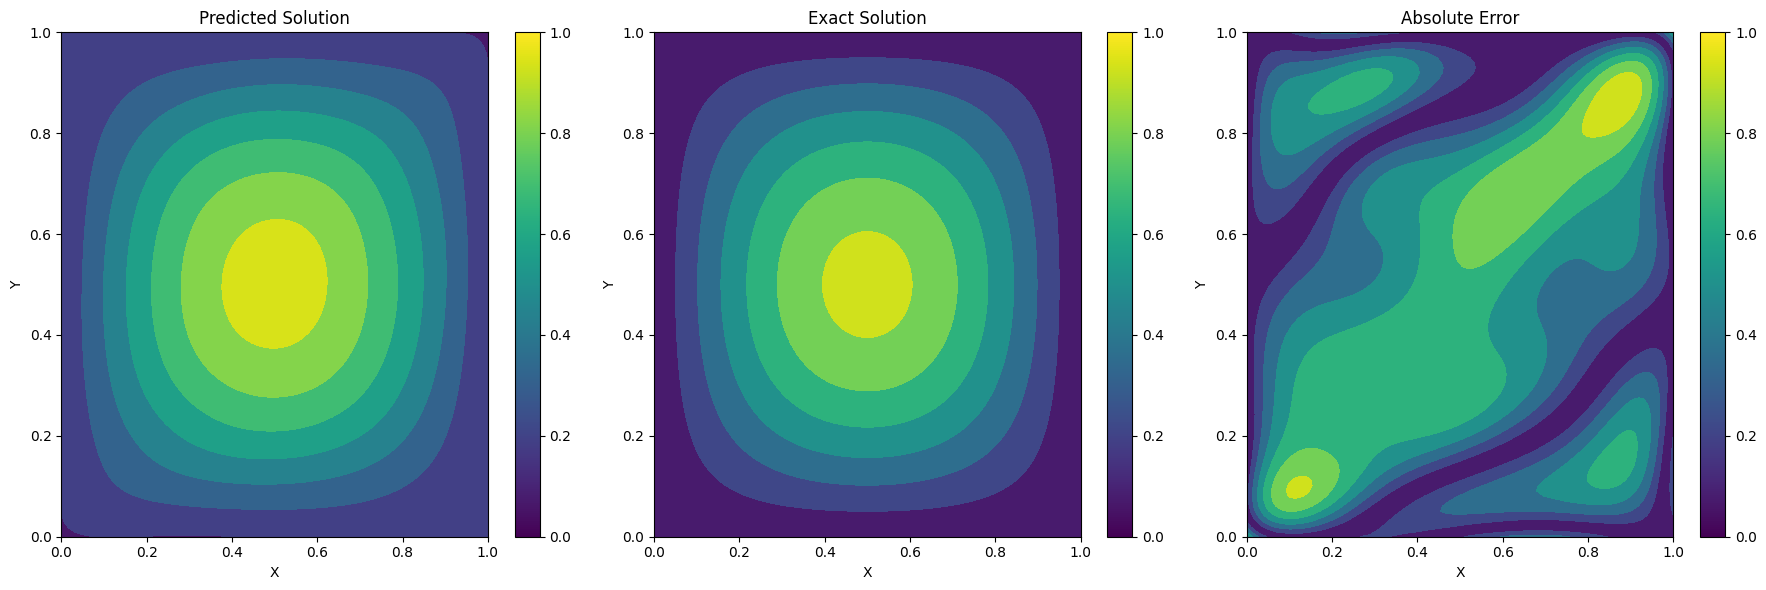

In [ ]:
#plotting graph
t_index = 25 #for t axis
fig , axis = plt.subplots(1 , 3 , figsize = (18,6))
#for u_pred
axis[0].contourf(X[:, :, t_index], Y[:, :, t_index], u_pred[:, :, t_index], cmap='viridis')
axis[0].set_title('Predicted Solution')
axis[0].set_xlabel('X')
axis[0].set_ylabel('Y')
fig.colorbar(axis[0].collections[0], ax=axis[0], orientation='vertical')
#for u_exact
axis[1].contourf(X[:, :, t_index], Y[:, :, t_index], u_exact[:, :, t_index], cmap='viridis')
axis[1].set_title('Exact Solution')
axis[1].set_xlabel('X')
axis[1].set_ylabel('Y')
fig.colorbar(axis[1].collections[0], ax=axis[1], orientation='vertical')
#for error
axis[2].contourf(X[:, :, t_index], Y[:, :, t_index], u_error[:, :, t_index], cmap='viridis')
axis[2].set_title('Absolute Error')
axis[2].set_xlabel('X')
axis[2].set_ylabel('Y')
fig.colorbar(axis[2].collections[0], ax=axis[2], orientation='vertical')
#showing the plot
plt.tight_layout()
plt.show()

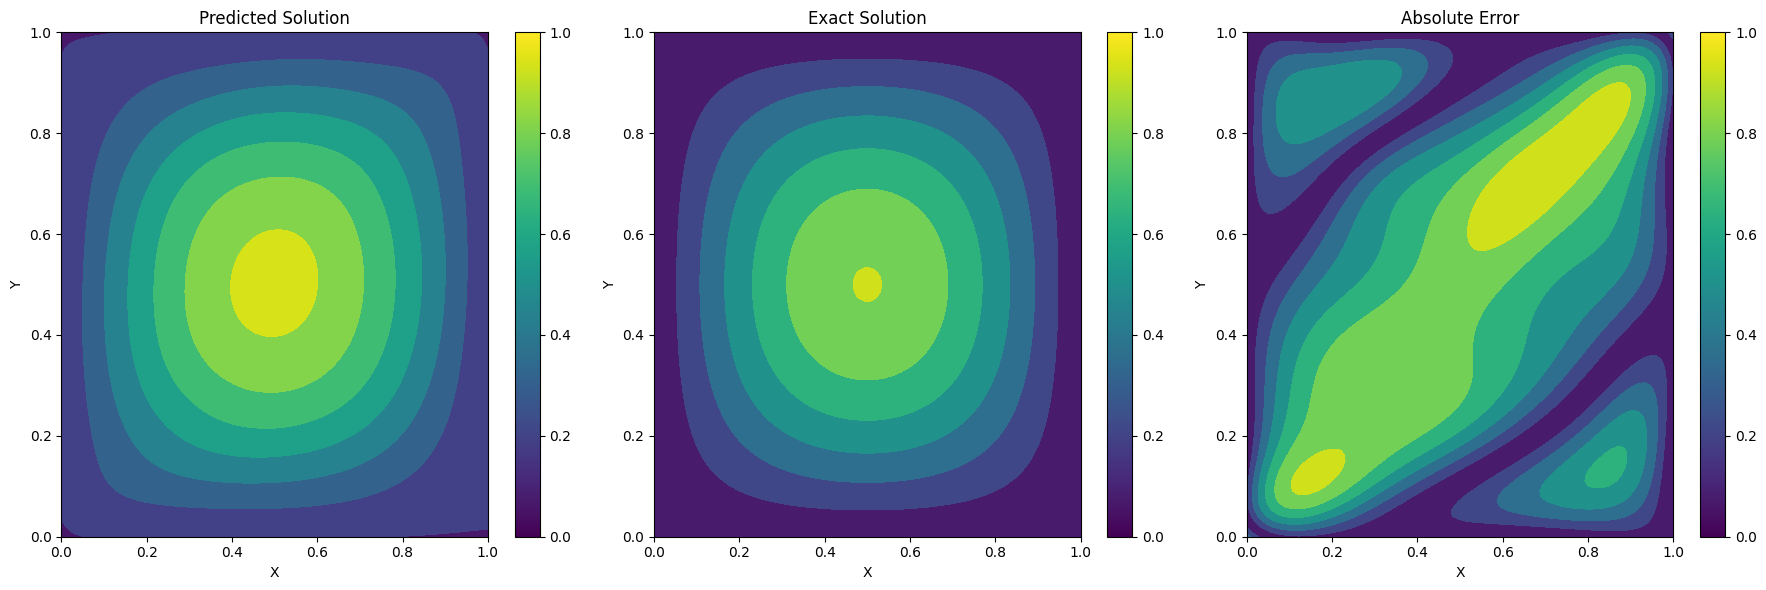

In [ ]:
#plotting graph
t_index = 50 #for t axis
fig , axis = plt.subplots(1 , 3 , figsize = (18,6))
#for u_pred
axis[0].contourf(X[:, :, t_index], Y[:, :, t_index], u_pred[:, :, t_index], cmap='viridis')
axis[0].set_title('Predicted Solution')
axis[0].set_xlabel('X')
axis[0].set_ylabel('Y')
fig.colorbar(axis[0].collections[0], ax=axis[0], orientation='vertical')
#for u_exact
axis[1].contourf(X[:, :, t_index], Y[:, :, t_index], u_exact[:, :, t_index], cmap='viridis')
axis[1].set_title('Exact Solution')
axis[1].set_xlabel('X')
axis[1].set_ylabel('Y')
fig.colorbar(axis[1].collections[0], ax=axis[1], orientation='vertical')
#for error
axis[2].contourf(X[:, :, t_index], Y[:, :, t_index], u_error[:, :, t_index], cmap='viridis')
axis[2].set_title('Absolute Error')
axis[2].set_xlabel('X')
axis[2].set_ylabel('Y')
fig.colorbar(axis[2].collections[0], ax=axis[2], orientation='vertical')
#showing the plot
plt.tight_layout()
plt.show()

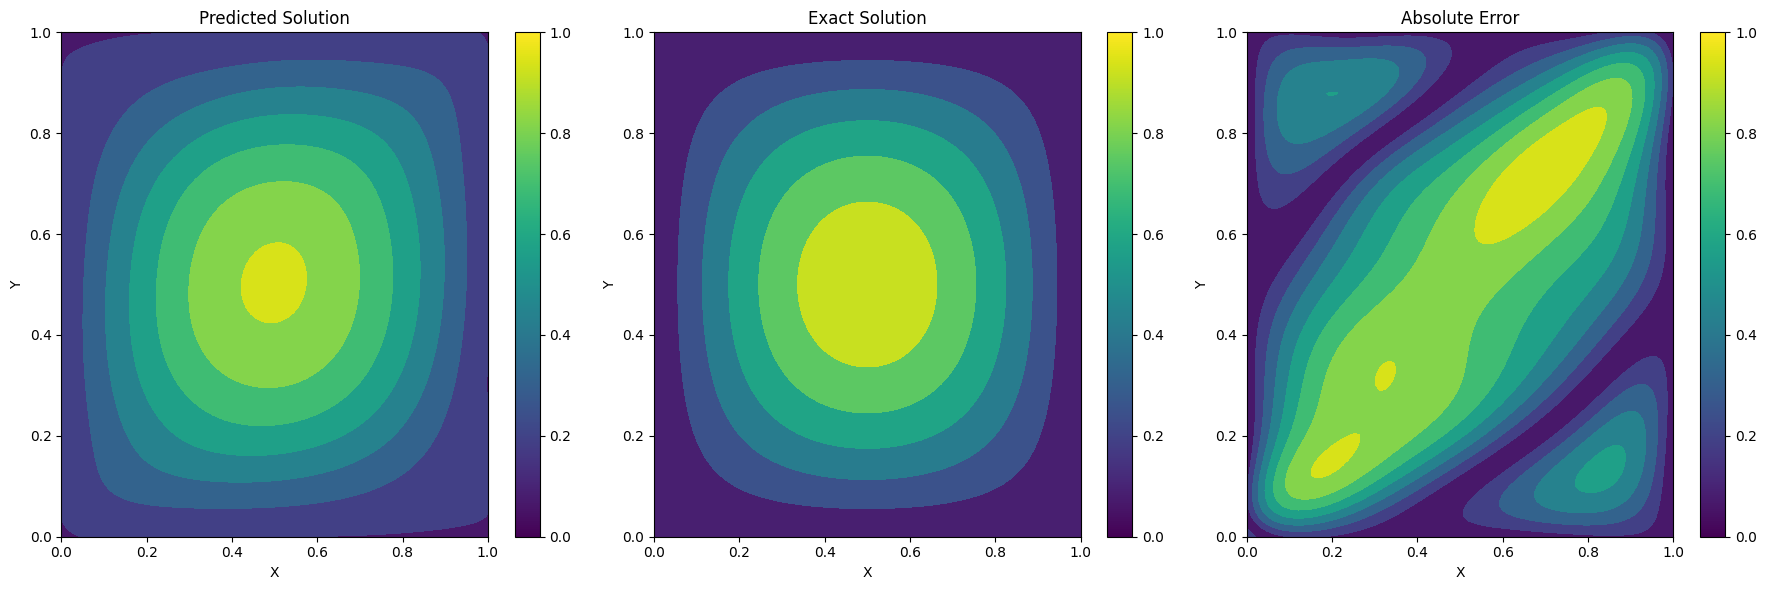

In [ ]:
#plotting graph
t_index = 75 #for t axis
fig , axis = plt.subplots(1 , 3 , figsize = (18,6))
#for u_pred
axis[0].contourf(X[:, :, t_index], Y[:, :, t_index], u_pred[:, :, t_index], cmap='viridis')
axis[0].set_title('Predicted Solution')
axis[0].set_xlabel('X')
axis[0].set_ylabel('Y')
fig.colorbar(axis[0].collections[0], ax=axis[0], orientation='vertical')
#for u_exact
axis[1].contourf(X[:, :, t_index], Y[:, :, t_index], u_exact[:, :, t_index], cmap='viridis')
axis[1].set_title('Exact Solution')
axis[1].set_xlabel('X')
axis[1].set_ylabel('Y')
fig.colorbar(axis[1].collections[0], ax=axis[1], orientation='vertical')
#for error
axis[2].contourf(X[:, :, t_index], Y[:, :, t_index], u_error[:, :, t_index], cmap='viridis')
axis[2].set_title('Absolute Error')
axis[2].set_xlabel('X')
axis[2].set_ylabel('Y')
fig.colorbar(axis[2].collections[0], ax=axis[2], orientation='vertical')
#showing the plot
plt.tight_layout()
plt.show()

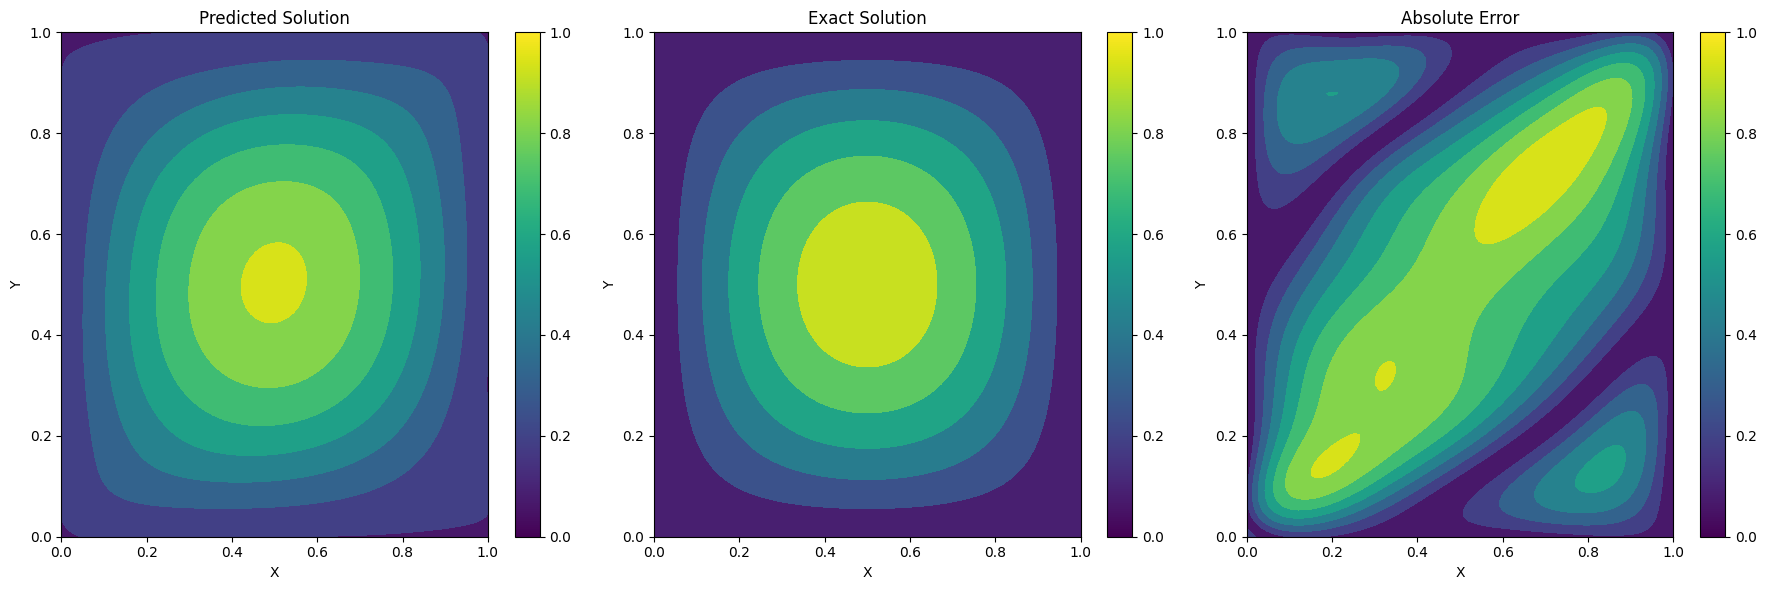

In [ ]:
#plotting graph
t_index = 75 #for t axis
fig , axis = plt.subplots(1 , 3 , figsize = (18,6))
#for u_pred
axis[0].contourf(X[:, :, t_index], Y[:, :, t_index], u_pred[:, :, t_index], cmap='viridis')
axis[0].set_title('Predicted Solution')
axis[0].set_xlabel('X')
axis[0].set_ylabel('Y')
fig.colorbar(axis[0].collections[0], ax=axis[0], orientation='vertical')
#for u_exact
axis[1].contourf(X[:, :, t_index], Y[:, :, t_index], u_exact[:, :, t_index], cmap='viridis')
axis[1].set_title('Exact Solution')
axis[1].set_xlabel('X')
axis[1].set_ylabel('Y')
fig.colorbar(axis[1].collections[0], ax=axis[1], orientation='vertical')
#for error
axis[2].contourf(X[:, :, t_index], Y[:, :, t_index], u_error[:, :, t_index], cmap='viridis')
axis[2].set_title('Absolute Error')
axis[2].set_xlabel('X')
axis[2].set_ylabel('Y')
fig.colorbar(axis[2].collections[0], ax=axis[2], orientation='vertical')
#showing the plot
plt.tight_layout()
plt.show()